In [ ]:
!nvidia-smi

!pip install -q roboflow pycocotools albumentations opencv-python-headless matplotlib tqdm torch torchvision


Fri Oct 17 15:34:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="QvEF48bm5UZyxJ1SrSTS")
project = rf.workspace("machine-learning-projects-zjy5k").project("brain-tumor-segmentation-ytnej")
version = project.version(2)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Brain-tumor-segmentation-2 in yolov11:: 100%|██████████| 224/224 [00:00<00:00, 5596.50it/s]


In [ ]:
import os
import cv2
import numpy as np
from glob import glob

# Paths
dataset_path = "/content/Brain-tumor-segmentation-2"
image_dir = os.path.join(dataset_path, "train/images")
label_dir = os.path.join(dataset_path, "train/labels")
mask_out_dir = os.path.join(dataset_path, "train/masks")  # will create this

os.makedirs(mask_out_dir, exist_ok=True)

# Convert YOLO polygons to masks
for label_file in glob(label_dir + "/*.txt"):
    # Match the corresponding image
    img_file_jpg = label_file.replace("labels", "images").replace(".txt", ".jpg")
    img_file_png = label_file.replace("labels", "images").replace(".txt", ".png")

    if os.path.exists(img_file_jpg):
        img_file = img_file_jpg
    elif os.path.exists(img_file_png):
        img_file = img_file_png
    else:
        print("Image not found for label:", label_file)
        continue

    # Load image to get size
    img = cv2.imread(img_file)
    h, w = img.shape[:2]

    # Start with blank mask
    mask = np.zeros((h, w), dtype=np.uint8)

    # Read YOLO label
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])  # class id
            coords = list(map(float, parts[1:]))

            # Convert normalized coords to pixels
            polygon = [(int(coords[i] * w), int(coords[i+1] * h)) for i in range(0, len(coords), 2)]
            polygon = np.array(polygon, dtype=np.int32)

            # Draw filled polygon
            cv2.fillPoly(mask, [polygon], 255)

    # Save mask
    mask_file = os.path.join(mask_out_dir, os.path.basename(label_file).replace(".txt", ".png"))
    cv2.imwrite(mask_file, mask)

print("✅ Masks created in:", mask_out_dir)


✅ Masks created in: /content/Brain-tumor-segmentation-2/train/masks


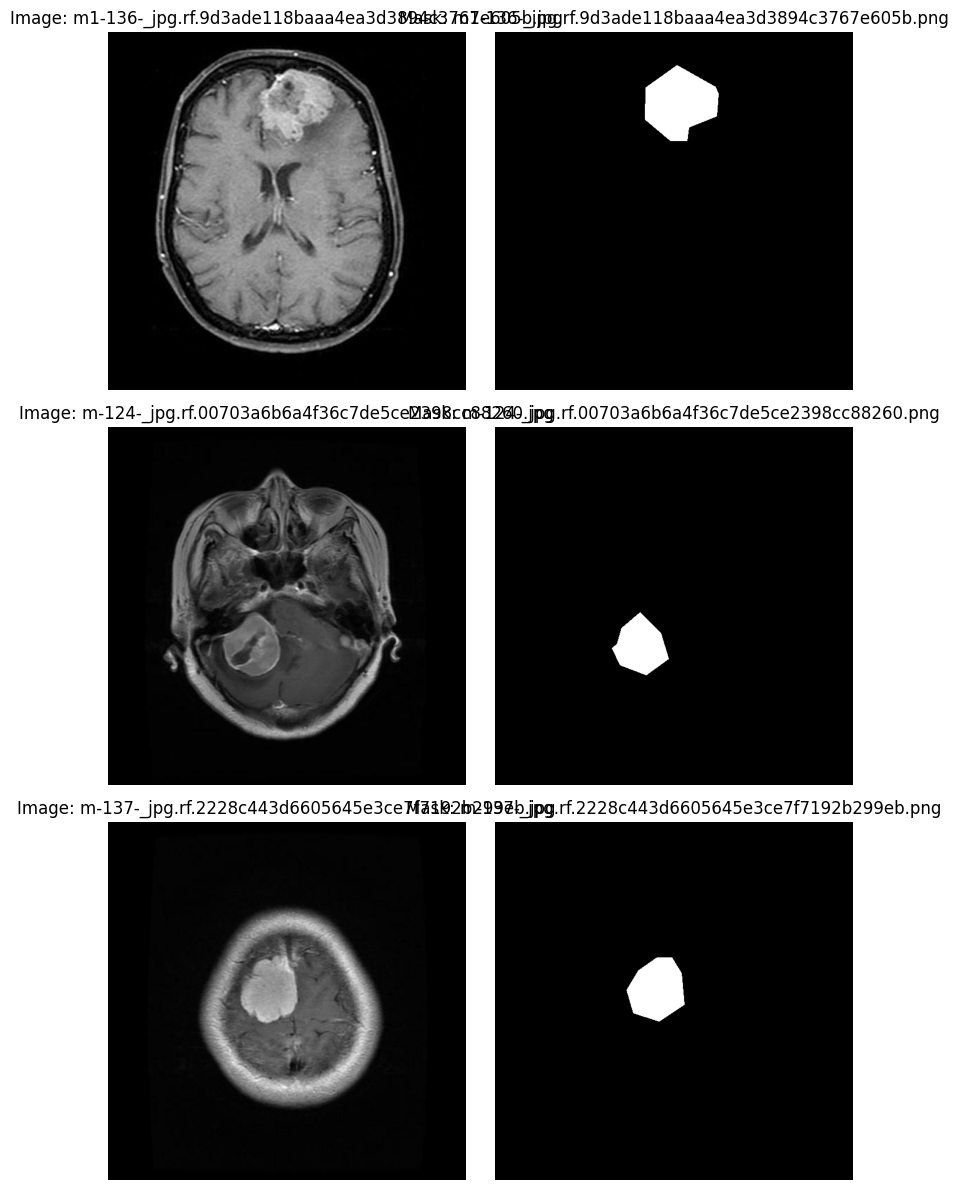

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

IMAGE_DIR = "/content/Brain-tumor-segmentation-2/train/images"
MASK_DIR  = "/content/Brain-tumor-segmentation-2/train/masks"

def show_random_samples(num_samples=3):
    img_files = os.listdir(IMAGE_DIR)

    # pick random samples
    samples = random.sample(img_files, num_samples)

    plt.figure(figsize=(8, num_samples*4))

    for i, img_name in enumerate(samples):
        img_path = os.path.join(IMAGE_DIR, img_name)
        base = os.path.splitext(img_name)[0]
        mask_path = os.path.join(MASK_DIR, base + ".png")

        # load image and mask
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # show image
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"Image: {img_name}")
        plt.axis("off")

        # show mask
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask: {base}.png")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show random 3 samples
show_random_samples(num_samples=3)


Create a PyTorch Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Custom dataset
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", ".png").replace(".png", ".png"))

        # load image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # binary mask
        mask = (mask > 0).astype("float32")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # add channel dim

        return image, mask

# Transforms
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

# Create dataset and dataloader
train_dataset = BrainTumorDataset(
    image_dir="/content/Brain-tumor-segmentation-2/train/images",
    mask_dir="/content/Brain-tumor-segmentation-2/train/masks",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Check one batch
images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)


Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- U-Net Building Blocks ---

class DoubleConv(nn.Module):
    """(Conv -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # If bilinear, use simple interpolation; otherwise, use ConvTranspose2d
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # output from the previous level (upsampled)
        x1 = self.up(x1)
       # Concatenate along the channel dimension (dim=1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# --- Full U-Net Model ---

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Initial Feature Map size
        base_c = 64

        # Encoder (Contracting Path)
        self.inc = DoubleConv(n_channels, base_c)
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = Down(base_c * 4, base_c * 8)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_c * 8, base_c * 16 // factor)

        # Decoder (Expansive Path)
        self.up1 = Up(base_c * 16, base_c * 8 // factor, bilinear)
        self.up2 = Up(base_c * 8, base_c * 4 // factor, bilinear)
        self.up3 = Up(base_c * 4, base_c * 2 // factor, bilinear)
        self.up4 = Up(base_c * 2, base_c, bilinear)
        self.outc = OutConv(base_c, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x) # 64
        x2 = self.down1(x1) # 128
        x3 = self.down2(x2) # 256
        x4 = self.down3(x3) # 512
        x5 = self.down4(x4) # 1024 or 512

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Final output
        logits = self.outc(x)
        return logits

# Initialize Model
model = UNet(n_channels=3, n_classes=1).to(DEVICE)
print(f"Model initialized and moved to {DEVICE}.")

with torch.no_grad():
    test_output = model(images.to(DEVICE))
    print("U-Net Output shape:", test_output.shape)

Using device: cuda
Model initialized and moved to cuda.
U-Net Output shape: torch.Size([4, 1, 256, 256])


In [ ]:
def dice_coeff(pred, target):
    smooth = 1e-6 # small constant to avoid division by zero


    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

# standard loss function:
criterion = nn.BCEWithLogitsLoss() # combines Sigmoid and BCE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 25
log_interval = 50

def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        total_dice = 0

        for batch_idx, (images, masks) in enumerate(dataloader):
            images = images.to(device) # [B, 3, H, W]
            masks = masks.to(device)   # [B, 1, H, W]

            # 1. Forward pass
            outputs = model(images)

            # 2. Calculate loss
            loss = criterion(outputs, masks)

            # 3. Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 4. Metrics calculation
            epoch_loss += loss.item()

            preds = torch.sigmoid(outputs)
            binary_preds = (preds > 0.5).float()

            dice = dice_coeff(binary_preds, masks)
            total_dice += dice.item()

            if (batch_idx + 1) % log_interval == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(dataloader)}], "
                      f"Loss: {loss.item():.4f}, Dice Coeff: {dice.item():.4f}")

        avg_loss = epoch_loss / len(dataloader)
        avg_dice = total_dice / len(dataloader)
        print(f"\n--- Epoch {epoch+1} finished. Avg Loss: {avg_loss:.4f}, Avg Dice Coeff: {avg_dice:.4f} ---\n")

print("Starting training...")
train_model(model, train_loader, criterion, optimizer, num_epochs, DEVICE)
print("Training complete.")

Starting training...

--- Epoch 1 finished. Avg Loss: 0.6729, Avg Dice Coeff: 0.1087 ---


--- Epoch 2 finished. Avg Loss: 0.4763, Avg Dice Coeff: 0.2825 ---


--- Epoch 3 finished. Avg Loss: 0.4291, Avg Dice Coeff: 0.4201 ---


--- Epoch 4 finished. Avg Loss: 0.4036, Avg Dice Coeff: 0.4876 ---


--- Epoch 5 finished. Avg Loss: 0.4113, Avg Dice Coeff: 0.4710 ---


--- Epoch 6 finished. Avg Loss: 0.3824, Avg Dice Coeff: 0.4989 ---


--- Epoch 7 finished. Avg Loss: 0.3634, Avg Dice Coeff: 0.4884 ---


--- Epoch 8 finished. Avg Loss: 0.3446, Avg Dice Coeff: 0.5885 ---


--- Epoch 9 finished. Avg Loss: 0.3332, Avg Dice Coeff: 0.6008 ---


--- Epoch 10 finished. Avg Loss: 0.3175, Avg Dice Coeff: 0.6718 ---


--- Epoch 11 finished. Avg Loss: 0.3141, Avg Dice Coeff: 0.6330 ---


--- Epoch 12 finished. Avg Loss: 0.3001, Avg Dice Coeff: 0.5896 ---


--- Epoch 13 finished. Avg Loss: 0.2901, Avg Dice Coeff: 0.6475 ---


--- Epoch 14 finished. Avg Loss: 0.2806, Avg Dice Coeff: 0.6900 ---


--- Epo

In [ ]:
import matplotlib.pyplot as plt

epoch_losses = [
    0.4304, 0.3116, 0.2844, 0.2556, 0.2390, 0.2216, 0.2132, 0.2081,
    0.2085, 0.1966, 0.1802, 0.1687, 0.1642, 0.1556, 0.1518, 0.1498,
    0.1400, 0.1343, 0.1282, 0.1252, 0.1265, 0.1191, 0.1150, 0.1088, 0.1040
]
epoch_dice_coeffs = [
    0.1766, 0.3100, 0.3648, 0.5179, 0.5212, 0.6390, 0.6351, 0.6745,
    0.6294, 0.6405, 0.7028, 0.7917, 0.7535, 0.7911, 0.7925, 0.7359,
    0.7814, 0.8351, 0.8525, 0.8435, 0.7811, 0.8056, 0.8090, 0.8238, 0.8703
]
epochs = range(1, len(epoch_losses) + 1)

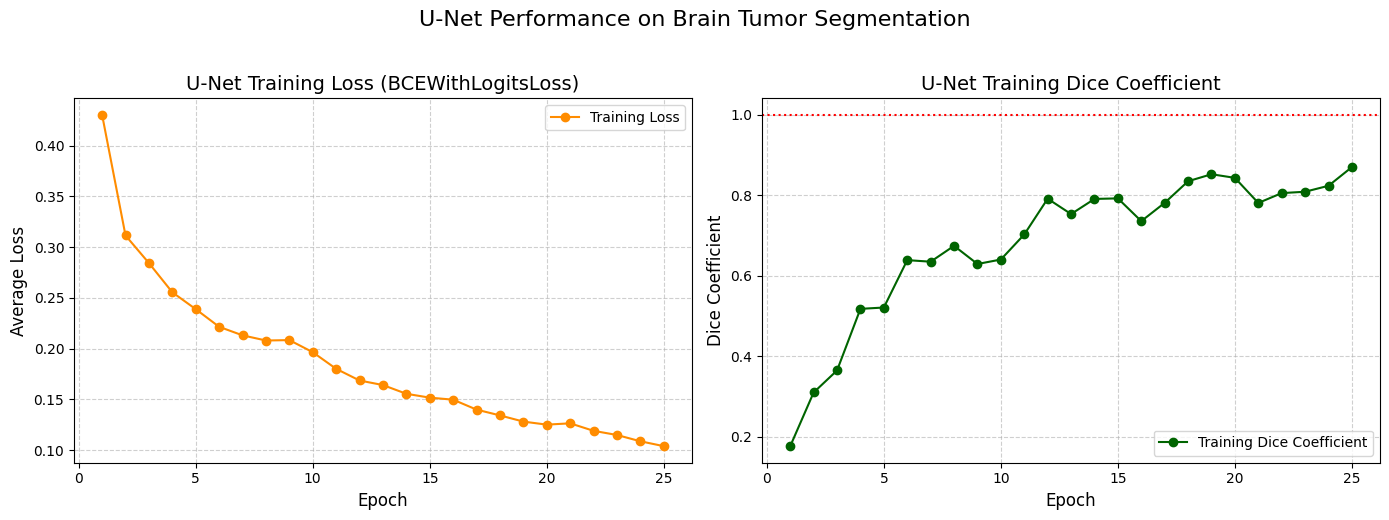

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ---  Training Loss ---
ax[0].plot(epochs, epoch_losses, label='Training Loss', color='darkorange', marker='o', linestyle='-')
ax[0].set_title('U-Net Training Loss (BCEWithLogitsLoss)', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Average Loss', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()

# ---  Dice Coefficient ---
ax[1].plot(epochs, epoch_dice_coeffs, label='Training Dice Coefficient', color='darkgreen', marker='o', linestyle='-')
ax[1].set_title('U-Net Training Dice Coefficient', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Dice Coefficient', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend()

ax[1].axhline(y=1.0, color='r', linestyle=':', label='Perfect Score (1.0)')

plt.suptitle('U-Net Performance on Brain Tumor Segmentation', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2


dataset_path = "/content/Brain-tumor-segmentation-2"
test_label_dir = os.path.join(dataset_path, "test/labels")
test_image_dir = os.path.join(dataset_path, "test/images")
test_mask_out_dir = os.path.join(dataset_path, "test/masks")

os.makedirs(test_mask_out_dir, exist_ok=True)

# Convert YOLO polygons to masks for the TEST set
for label_file in glob(test_label_dir + "/*.txt"):
    img_file_jpg = label_file.replace("labels", "images").replace(".txt", ".jpg")
    img_file_png = label_file.replace("labels", "images").replace(".txt", ".png")

    if os.path.exists(img_file_jpg):
        img_file = img_file_jpg
    elif os.path.exists(img_file_png):
        img_file = img_file_png
    else:
        continue

    img = cv2.imread(img_file)
    if img is None: continue
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            coords = list(map(float, parts[1:]))
            polygon = [(int(coords[i] * w), int(coords[i+1] * h)) for i in range(0, len(coords), 2)]
            polygon = np.array(polygon, dtype=np.int32)
            cv2.fillPoly(mask, [polygon], 255)

    mask_file = os.path.join(test_mask_out_dir, os.path.basename(label_file).replace(".txt", ".png"))
    cv2.imwrite(mask_file, mask)

print("✅ Masks created for test set in:", test_mask_out_dir)

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

test_dataset = BrainTumorDataset(
    image_dir=test_image_dir,
    mask_dir=test_mask_out_dir,
    transform=test_transform
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test dataset size: {len(test_dataset)} samples.")

✅ Masks created for test set in: /content/Brain-tumor-segmentation-2/test/masks
Test dataset size: 10 samples.



Starting visualization of U-Net predictions on the TEST set...


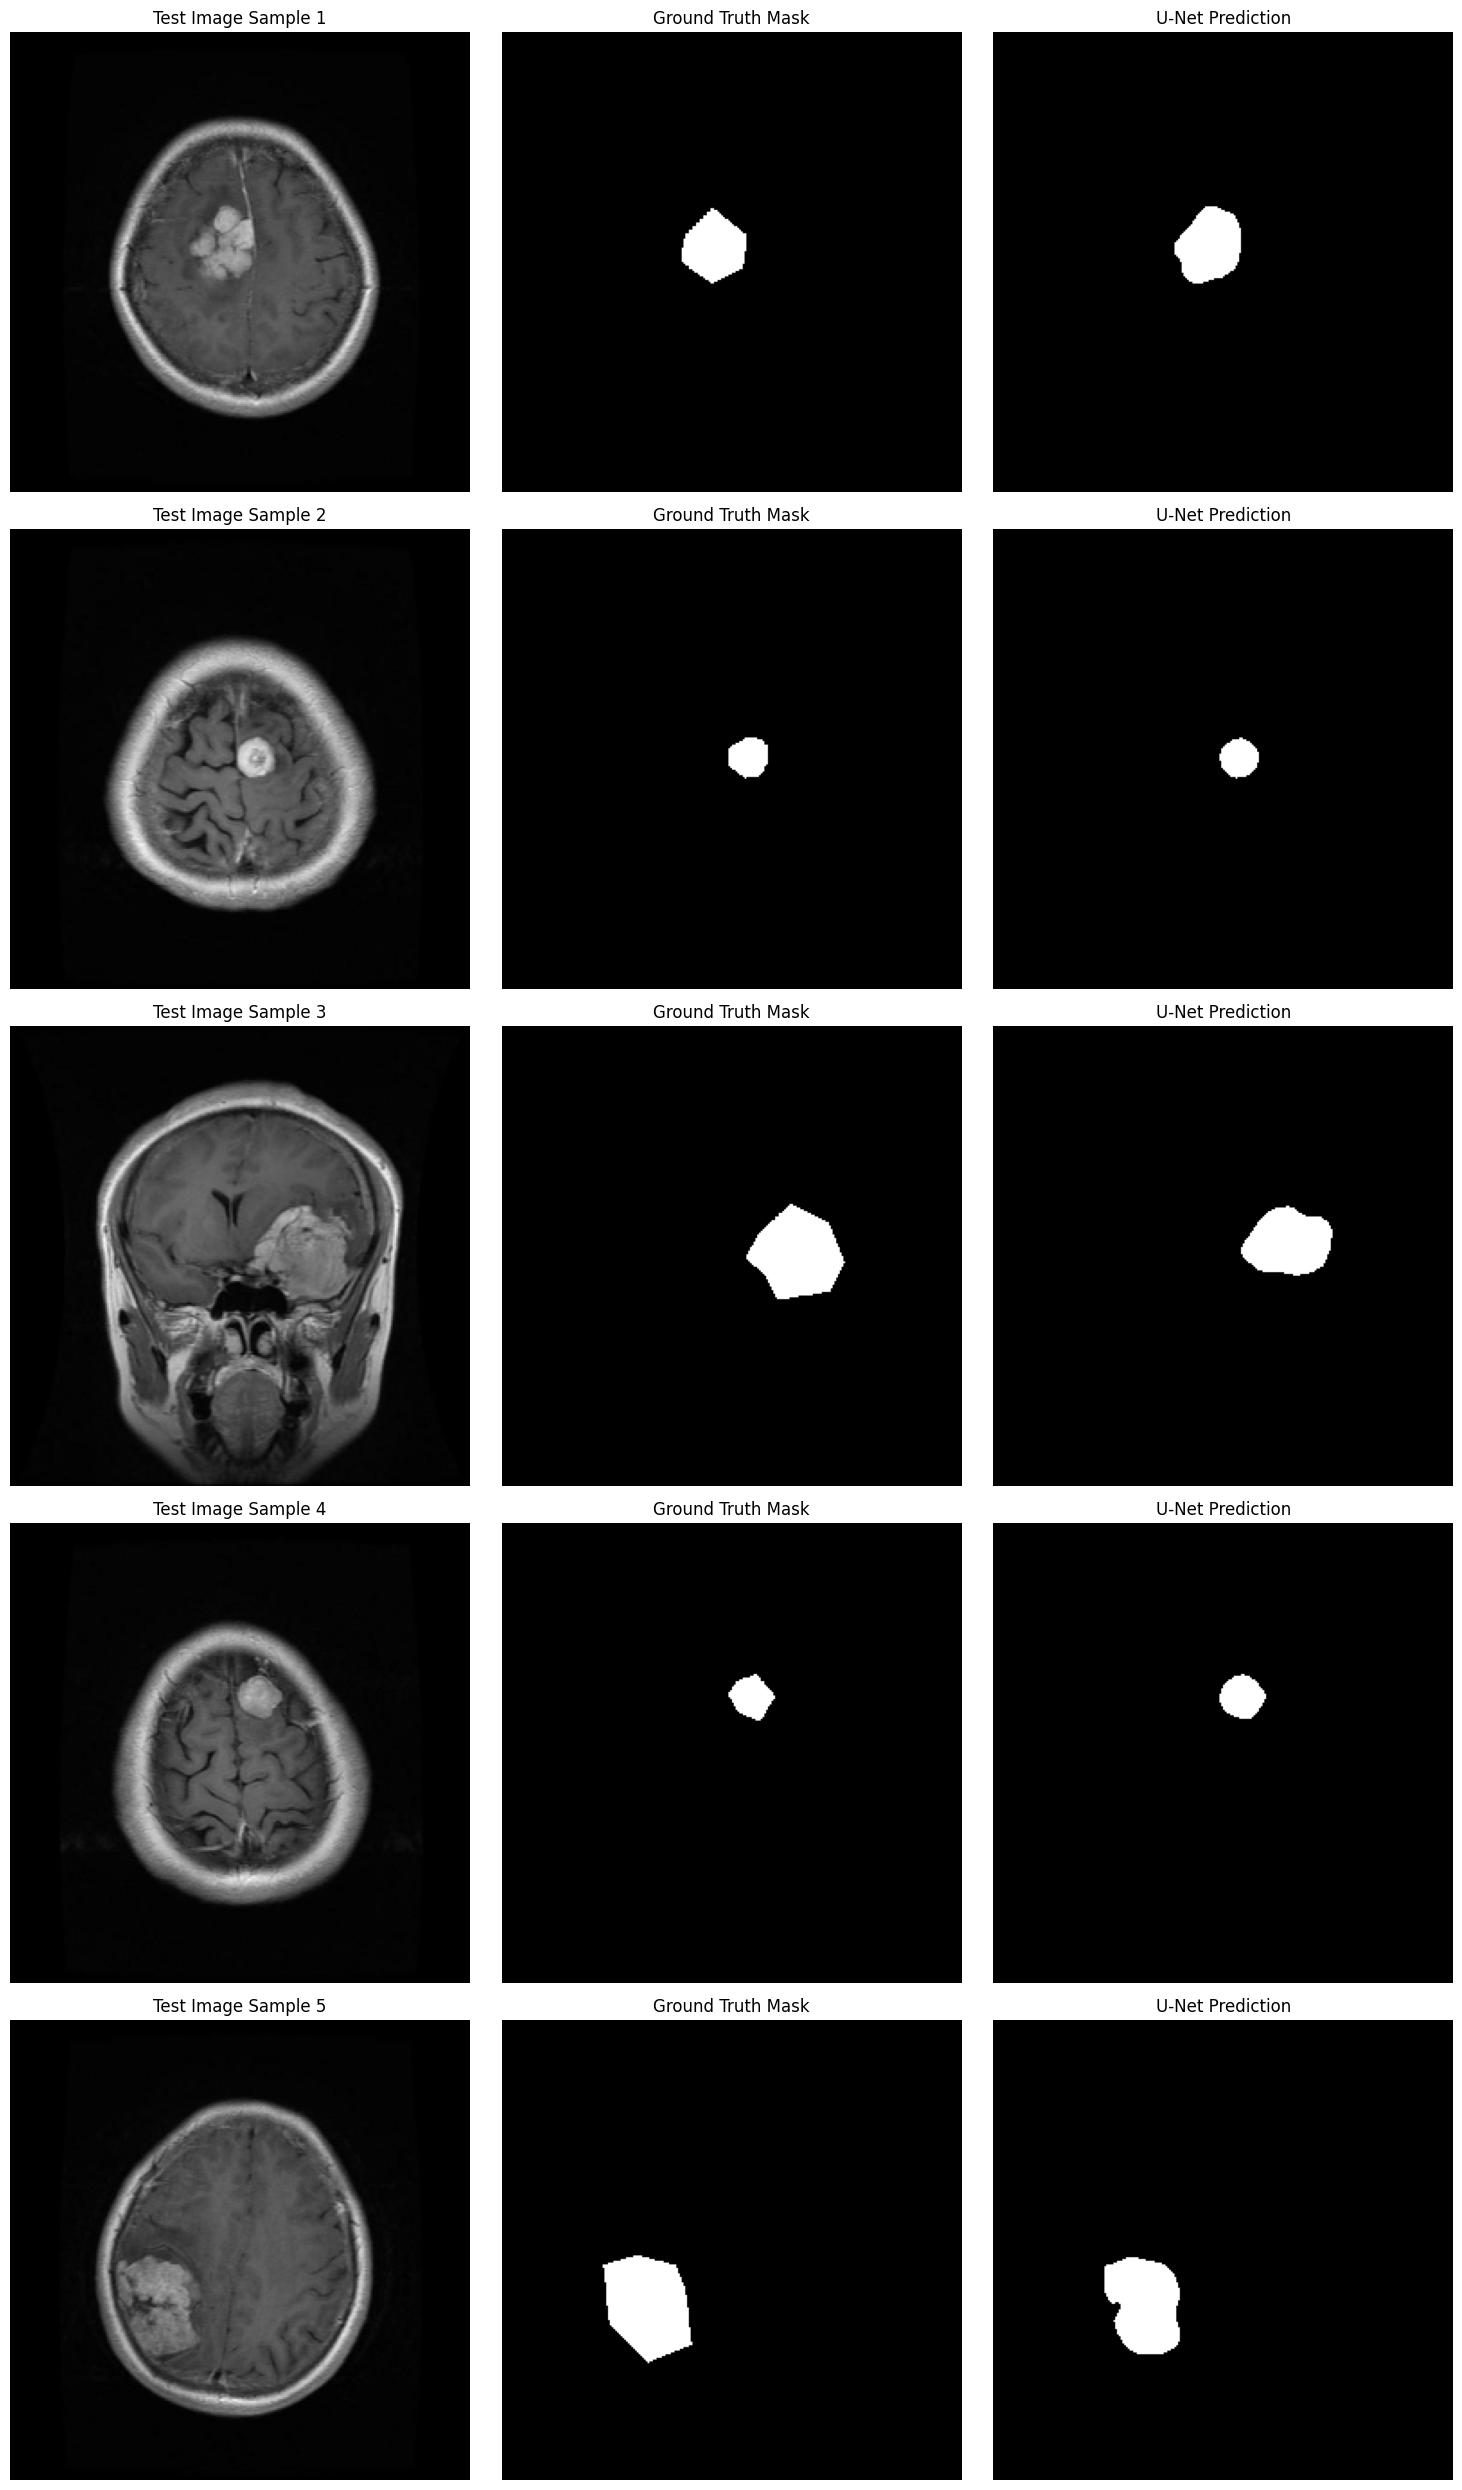

In [ ]:
def visualize_predictions(model, dataloader, num_samples=3):
    model.eval()

    data_iterator = iter(dataloader)

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        try:
            # Load next sample
            images, true_masks_tensor = next(data_iterator)
        except StopIteration:
            print(f"Reached end of dataset after visualizing {i} samples.")
            break

        images = images.to(DEVICE)

        with torch.no_grad():
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            predicted_masks_tensor = (preds > 0.5).float()

        img_cpu = images.cpu().numpy()[0]
        true_mask_cpu = true_masks_tensor.cpu().numpy()[0, 0]
        pred_mask_cpu = predicted_masks_tensor.cpu().numpy()[0, 0]

        img_display = np.transpose(img_cpu, (1, 2, 0))


        # Subplot 1: Original Image
        ax1 = plt.subplot(num_samples, 3, 3*i + 1)
        ax1.imshow(img_display)
        ax1.set_title(f"Test Image Sample {i+1}")
        ax1.axis('off')

        # Subplot 2: Ground Truth Mask
        ax2 = plt.subplot(num_samples, 3, 3*i + 2)
        ax2.imshow(true_mask_cpu, cmap='gray')
        ax2.set_title("Ground Truth Mask")
        ax2.axis('off')

        # Subplot 3: Predicted Mask
        ax3 = plt.subplot(num_samples, 3, 3*i + 3)
        ax3.imshow(pred_mask_cpu, cmap='gray')
        ax3.set_title("U-Net Prediction")
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

print("\nStarting visualization of U-Net predictions on the TEST set...")
visualize_predictions(model, test_loader, num_samples=5)